In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# change to set working directory as required
path = 'C:/Users/Dell/Documents/4thYearProject/primary_data/'
os.chdir(path)

## Hyperparameter/Network settings

batch_size = number of samples used before updating model parameters 

n_epochs = maximum number of complete passes through the training set (with early stopping also implemented)

seq_len = length of sample slices in datasets

kernel_size = width of 1D convolutional filters

n_classes = number of classes for classification (assumed binary here)

n_channels = number of input channels/sequences per sample (4 in this case for r chest, l chest, r abdomen, l abdomen)

In [3]:
kernel_size = 49

In [4]:
n_classes = 2
n_channels = 4

n_layers = 3
n_filters = [8, 16, 32, 64] 

batch_size = 32
n_epochs = 5000
seq_len = 1000

learning_rate = 1e-5
keep_prob = 0.2

Enter name for new run or path of previous run to reload trained model

In [5]:
runID = "checkpoints-cnn/slp_filters41.ckpt"

# 1. Loading in data

In [6]:
def read_data(data_path, dataset_name, seq_len):
    
    label_path = os.path.join(data_path, dataset_name + '_labels.csv')
    sample_names = pd.read_csv(os.path.join(data_path, dataset_name + '_names.csv'), header=None)
    sample_names = sample_names.values
    labels = pd.read_csv(label_path, header=None)
    labels = labels.values.astype('float32')
    
    
    ch_list = ['q1', 'q2', 'q3', 'q4']
    
    X = np.zeros((len(labels), seq_len, len(ch_list)))
    
    for num, ch in enumerate(ch_list):
        chi_path = os.path.join(data_path, dataset_name + '_' + ch + '.csv')
        ch = pd.read_csv(chi_path, header=None)
        ch = ch.fillna(0)
        ch_array = ch.values
        
        # 0 pad arrays with sequences < seq_len
        if ch_array.shape[1] != seq_len:
            zero_padding = np.zeros((len(labels), seq_len-ch_array.shape[1]))
            ch_array = np.concatenate(ch_array, zero_padding, axis=1)
        
        X[:, :, num] = ch_array
    
    
    return X, labels, sample_names

## Matched cohort of normal-asthmatic/wheezing children

Using multiple slices from matched cohort samples

In [7]:
# Paths to asthma and normal training data CSVs extracted using get_clf_inputs.py
matched_asthma_path = './healthy_asthma_data/Asthma_slices_1000/'
matched_healthy_path = './healthy_asthma_data/Healthy_slices_1000/'
matched_asthma_name = 'Asthma_1000'
matched_healthy_name = 'Healthy_1000'



X_asthma, labels_asthma, sample_names_asthma = read_data(matched_asthma_path,
                                                         matched_asthma_name,
                                                        seq_len)
X_healthy, labels_healthy, sample_names_healthy = read_data(matched_healthy_path,
                                                           matched_healthy_name,
                                                           seq_len)

X = np.concatenate((X_asthma, X_healthy), axis=0)
labels = np.concatenate((labels_asthma, labels_healthy), axis=0)
sample_names = np.concatenate((sample_names_asthma, sample_names_healthy), axis=0)

## Held out (noncohort) normal-asthma data for testing

Set comprises child asthma-wheezing samples and remaining normals (adults and children)

In [8]:
# Paths to asthma and normal test data CSVs extracted using get_clf_inputs.py

noncohort_asthma_path = './healthy_asthma_noncohort_data/Asthma_noncohort_1000/'
noncohort_healthy_path = './healthy_asthma_noncohort_data/Healthy_noncohort_1000/'

noncohort_asthma_name = 'Asthma_noncohort_1000'
noncohort_healthy_name = 'Healthy_noncohort_1000'

In [9]:
X_noncohort_a, labels_noncohort_a, names_noncohort_a = read_data(noncohort_asthma_path,
                                                          noncohort_asthma_name,
                                                          seq_len)
X_noncohort_h, labels_noncohort_h, names_noncohort_h = read_data(noncohort_healthy_path,
                                                          noncohort_healthy_name,
                                                          seq_len)

X_noncohort = np.concatenate((X_noncohort_a, X_noncohort_h), axis=0)
labels_noncohort = np.concatenate((labels_noncohort_a, labels_noncohort_h), axis=0)
names_noncohort = np.concatenate((names_noncohort_a, names_noncohort_h), axis=0)

## Additional dataset testing on different asthma groups

### Adult asthmatics

Labelled as abnormal 

In [10]:
aa_path = '../Additional_abnormals/Adult_asthma/slices_1000/'
aa_name = 'Adult_asthma'

In [11]:
X_aa, labels_aa, names_aa = read_data(aa_path, aa_name, seq_len)

### Acute asthmatics 

Includes pre & post-bronchodilator samples for children aged 2-17

Labelled as abnormal

In [12]:
aca_path = '../Additional_abnormals/Asthma_acute/slices_1000/'
aca_name = 'Asthma_acute'

In [13]:
X_aca, labels_aca, names_aca = read_data(aca_path, aca_name, seq_len)

### Stable asthmatics 

Includes pre & post-bronchodilator samples for children aged 4-15

Labelled as abnormal

In [14]:
sa_path = '../Additional_abnormals/Asthma_stable/slices_1000/'
sa_name = 'Asthma_stable'

In [15]:
X_sa, labels_sa, names_sa = read_data(sa_path, sa_name, seq_len)

# 2. Train-test-validation split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
num_samples = X.shape[0]
indices = np.arange(num_samples)

In [18]:
X_train, x_test, y_train, y_test, tr_idx, te_idx = train_test_split(X, labels, indices, test_size=0, random_state=123,
                                                   shuffle=True)

In [19]:
X_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123,
                                                   shuffle=True)

In [20]:
print('Training set size: ', X_tr.shape[0])
print('Validation set size: ', x_val.shape[0])

Training set size:  485
Validation set size:  122


In [21]:
print('Noncohort set size: ', X_noncohort.shape[0])
print('Adult asthma set size: ', X_aa.shape[0])
print('Acute asthma set size: ', X_aca.shape[0])
print('Stable asthma set size: ', X_sa.shape[0])

Noncohort set size:  1369
Adult asthma set size:  180
Acute asthma set size:  854
Stable asthma set size:  594


In [22]:
test_set = {'noncohort': X_noncohort, 
            'adult_asthma': X_aa, 
            'acute_asthma': X_aca, 
            'stable_asthma': X_sa}

test_set_names = {'noncohort': names_noncohort, 
                  'adult_asthma': names_aa, 
                  'acute_asthma': names_aca, 
                  'stable_asthma': names_sa}

test_set_labels = {'noncohort': labels_noncohort, 
                   'adult_asthma': labels_aa, 
                   'acute_asthma': labels_aca, 
                   'stable_asthma': labels_sa}

# 3. One hot encoding of labels

In [23]:
def one_hot_encode(labels):
    num_lbls = labels.shape[0]
    
    labels_encoded = np.zeros((num_lbls, 2))
    labels_encoded[:, 0] = (labels == 0).astype(np.int).reshape(num_lbls)
    labels_encoded[:, 1] = (labels == 1).astype(np.int).reshape(num_lbls)
    
    return labels_encoded

In [24]:
y_tr = one_hot_encode(y_tr)
y_val = one_hot_encode(y_val)

test_set_labels_encoded = {}
for key in test_set_labels:
    y_encoded = one_hot_encode(test_set_labels[key])
    test_set_labels_encoded[key] = y_encoded

# 4. Construct CNN graph

In [29]:
graph = tf.Graph()

with graph.as_default():
    tf.random.set_random_seed(1234)
    
    # Set placeholders for inputs and labels in graph
    inputs_ = tf.placeholder(tf.float32, shape=[None, seq_len, n_channels], name='inputs')
    labels_ = tf.placeholder(tf.float32, shape=[None, n_classes], name = 'labels')
    
    # keep probability used for dropout
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    
    # learning rate used in Adam optimisation
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [30]:
def conv1d(x, W, b, strides=1):
    x = tf.nn.conv1d(x, W, strides, padding='SAME')
    x = tf.nn.bias_add(x, b)
    
    return tf.nn.relu(x)

In [31]:
with graph.as_default():
    tf.random.set_random_seed(1234)
    
    weights = {
        'wc1': tf.get_variable("wc1", [kernel_size, 4, 8]),
        'wc2': tf.get_variable("wc2", [kernel_size, 8, 16]),
        'wc3': tf.get_variable("wc3", [kernel_size, 16, 32]),
        'wc4': tf.get_variable("wc4", [kernel_size, 32, 64])}
    biases = {
        'bc1': tf.get_variable("bc1", [8]), 
        'bc2': tf.get_variable("bc2", [16]),
        'bc3': tf.get_variable("bc3", [32]),
        'bc4': tf.get_variable("bc4", [64])}
    
    conv1 = conv1d(inputs_, weights['wc1'], biases['bc1'])
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    conv2 = conv1d(max_pool_1, weights['wc2'], biases['bc2'])
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    
    conv3 = conv1d(max_pool_2, weights['wc3'], biases['bc3'])
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    
    #conv4 = conv1d(max_pool_3, weights['wc4'], biases['bc4'])
    #max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Flatten output and pass to classifier

In [32]:
with graph.as_default():
    tf.random.set_random_seed(1234)
    num_units = int(seq_len*np.exp2(-n_layers))*n_filters[n_layers-1]
    flat = tf.reshape(max_pool_3, (-1, num_units))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions for each class
    logits = tf.layers.dense(flat, n_classes) 
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Define batch generator

returns generator object - iterator (like a list) but can iterate over it only once (more memory efficient)

In [33]:
def get_batches(X, y, batch_size):
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# 5. Train network 

### (if reloading a trained model, skip to 6 without running cells in section 5)

In [ ]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

### Choose savepath

In [ ]:
%%time
validation_acc = []
validation_loss = []
train_acc = []
train_loss = []
epochs_since_decrease = 0
epoch_losses = []

with graph.as_default():
    tf.random.set_random_seed(1234)
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as sess:
    tf.random.set_random_seed(1234)
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    # Loop over epochs
    for e in range(n_epochs):
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            # Feed dictionary
            
            assert not np.any(np.isnan(x))
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Get loss & accuracy for this iteration
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, n_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(x_val, y_val, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, n_epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
        
        # Compute validation loss for each epoch
        val_loss_e = []
        for x_v, y_v in get_batches(x_val, y_val, batch_size):
            # Feed
            feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
            # Loss
            loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
            val_loss_e.append(loss_v)
        
        # stop if validation loss doesn't decrease for 100 epochs 
        epoch_loss = np.mean(val_loss_e)
        if e==0:
            pass
        else:
            if epoch_loss > np.mean(epoch_losses):
                epochs_since_decrease += 1
            else:
                epochs_since_decrease = 0
            if epochs_since_decrease >= 100:
                print('Stopping at epoch %d' % e)
                break
                
        epoch_losses.append(epoch_loss)
    
    
    saver.save(sess, runID)
print()

In [ ]:
# Plot training and test loss
%matplotlib notebook
t = np.arange(iteration-1)
t2 = t[t % 10 == 0]

if len(t2) > len(validation_loss):
    # remove 0 as first element
    t2 = t2[1:]

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t2, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t2, validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# 6. Test on heldout datasets

In [34]:
with graph.as_default():
    tf.random.set_random_seed(1234)
    saver = tf.train.Saver()

In [35]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
def save_results(pred_1, pred_0, acc, names, lbls, run_name, path, set_name):
    d = {'Name': names, 'Label':lbls, 'Acc':acc, 'pr(abnormal)': pred_1, 'pr(normal)': pred_0}
    df = pd.DataFrame(data=d)
    model_name = (run_name.rsplit("/", 1)[-1]).rsplit(".", 1)[0]
    f_name = model_name + set_name + '_testresults.csv'
    
    save_path = path + "/Results/Test_results/" + f_name
    export_csv = df.to_csv(save_path, header=True, index=False)
    print("Saved to path ")
    print(save_path)

In [36]:
cms = [np.zeros((2, 2)), np.zeros((2, 2)),np.zeros((2, 2)), np.zeros((2, 2))]

save_pr = 0


with tf.Session(graph=graph) as sess:
    tf.random.set_random_seed(1234)
    # Restore
    #restore_point = tf.train.latest_checkpoint('checkpoints-cnn')
    restore_point = runID
    saver.restore(sess, restore_point)
    
    cm_counter = 0
    for set_name in test_set:
        print('\n\n%s TESTING' % set_name)
        test_acc = [] 
        counter = 0
        
        cm = cms[cm_counter]
        X_test = test_set[set_name]
        y_test = test_set_labels_encoded[set_name]
        test_names = test_set_names[set_name]
        
        pr_1 = []
        pr_0 = []
        acc_list = []
        names = []
        lbls = []
        for x_t, y_t in get_batches(X_test, y_test, batch_size=1):
            ## Relabel postbronchodilator samples as normal
            tmp_name = test_names[counter][0]
            if "Post" in tmp_name:
                y_t = 1 - y_t
            feed = {inputs_: x_t,
                    labels_: y_t,
                    keep_prob_: 1}
            
            
            batch_acc, class_logits = sess.run([accuracy, logits], feed_dict=feed)
            test_acc.append(batch_acc)
            
            class_probs = softmax(class_logits)
            
            """
            if batch_acc == 0:
                print('Label: ', np.argmax(y_t), 
                      ' Class probabilities: ', class_probs[0], 
                      ' Accuracy: ', batch_acc,
                      ' Name: ', test_names[counter])
            """
            
            pr_1.append(class_probs[0][1])
            pr_0.append(class_probs[0][0])
            acc_list.append(batch_acc)
            names.append(test_names[counter][0])
            lbls.append(np.argmax(y_t))
            cm[int(np.argmax(y_t)), int(batch_acc)] += 1
            counter += 1

        print("\nTest accuracy: {:.6f}".format(np.mean(test_acc)))
        # Confusion matrix
        confusion = np.zeros((2,2))
        confusion[0, 0] = cm[1, 1]
        confusion[1, 0] = cm[1, 0]
        confusion[0, 1] = cm[0, 0]
        confusion[1, 1] = cm[0, 1]
        
        print('\nCONFUSION MATRIX')
        print(confusion)
        
        if save_pr == 1:
            save_results(pr_1, pr_0, acc_list, names, lbls, runID, path, set_name)     
        
        cm_counter += 1

INFO:tensorflow:Restoring parameters from checkpoints-cnn/slp_filters41.ckpt


noncohort TESTING

Test accuracy: 0.932798

CONFUSION MATRIX
[[  98.   63.]
 [  29. 1179.]]


adult_asthma TESTING

Test accuracy: 0.022222

CONFUSION MATRIX
[[  4.   0.]
 [176.   0.]]


acute_asthma TESTING

Test accuracy: 0.539813

CONFUSION MATRIX
[[247. 209.]
 [184. 214.]]


stable_asthma TESTING

Test accuracy: 0.447811

CONFUSION MATRIX
[[ 29.  60.]
 [268. 237.]]


# 7. View Filters

CH1 = R CHEST

CH2 = L CHEST

CH3 = R ABDOMEN

CH4 = L ABDOMEN

In [37]:
def weights_reshape(w):
    w_reshaped = np.zeros((w.shape[1], w.shape[0], w.shape[2]))
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            w_reshaped[j, i, :] = w[i][j]
            
    return w_reshaped

In [38]:
with tf.Session(graph=graph) as sess:
    restore_point = runID
    #restore_point = tf.train.latest_checkpoint('checkpoints-cnn')

    saver.restore(sess, restore_point)
    w1 = sess.run(weights['wc1'])
    w2 = sess.run(weights['wc2'])
    w3 = sess.run(weights['wc3'])
    w_reshaped = weights_reshape(w1)
    w_reshaped2 = weights_reshape(w2)
    w_reshaped3 = weights_reshape(w3)
    

INFO:tensorflow:Restoring parameters from checkpoints-cnn/slp_filters41.ckpt


In [57]:
from scipy import signal

# to smooth trained convolutional filter weights using savitzky golay filters
def smooth_volume(v_list, smooth=True):
    if smooth:
        poly_deg = 3
        window_size = 15
        smoothed = signal.savgol_filter(v_list, window_size, poly_deg)
        return smoothed
    else:
        return v_list

In [58]:
def plot_smoothed_filter(ax, filter_num, kernel_size, weights):
    line1, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[0, :, filter_num]), label='R Chest', 
                     c='gold')
    
    line2, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[1, :, filter_num]), label='L Chest', 
                     c='red')
                     
    line3, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[2, :, filter_num]), label='R Abdomen',
                    c='green')
    line4, = ax.plot(np.linspace(0, kernel_size-1, kernel_size), smooth_volume(weights[3, :, filter_num]), label='L Abdomen',
                        c='blue')
    
    ax.set_ylabel('Value')

    

<IPython.core.display.Javascript object>


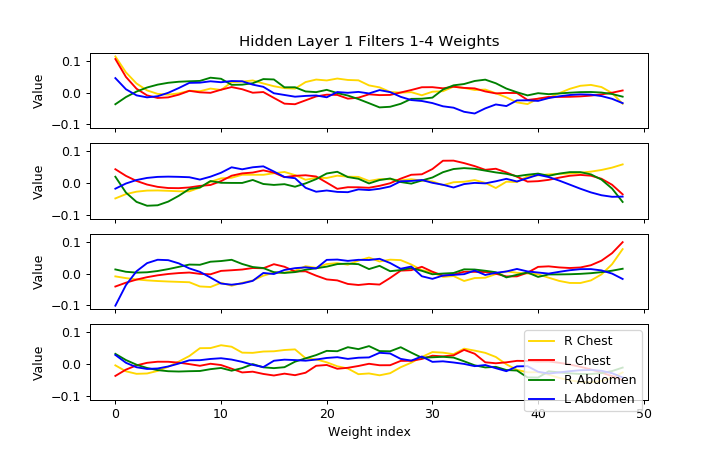

In [59]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped)

ax1.set_title('Hidden Layer 1 Filters 1-4 Weights')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


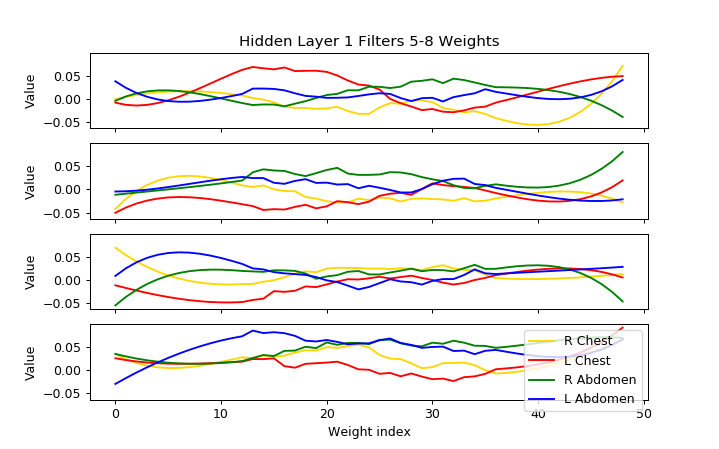

In [42]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped)

ax1.set_title('Hidden Layer 1 Filters 5-8 Weights')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


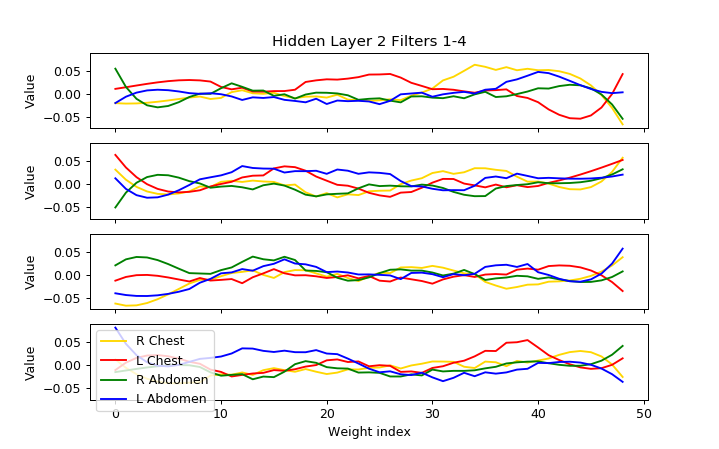

In [60]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 1-4')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


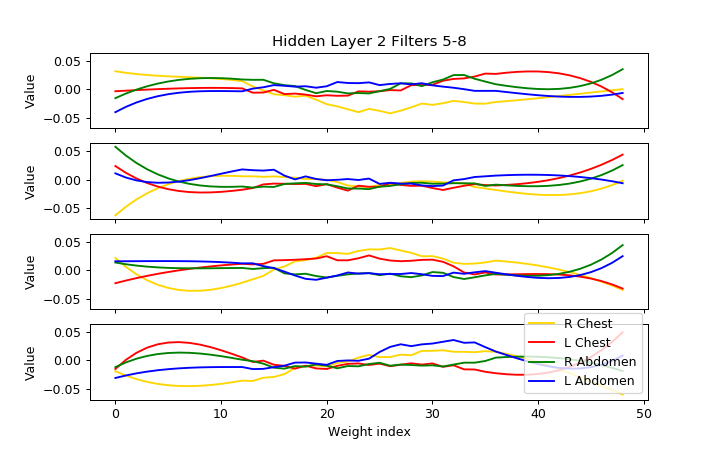

In [44]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 5-8')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


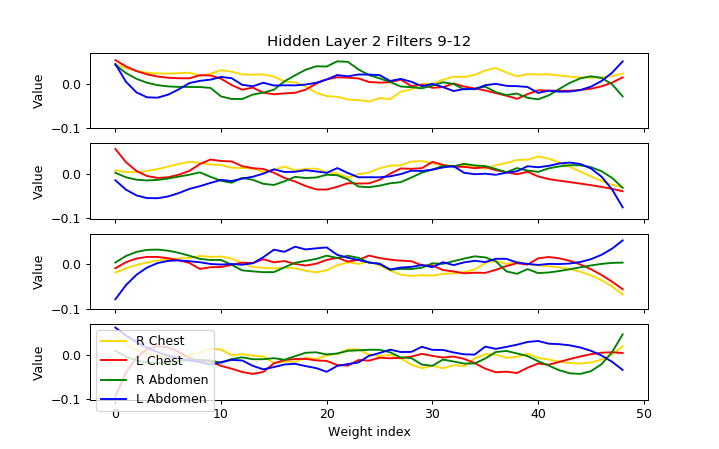

In [61]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+8, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 9-12')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


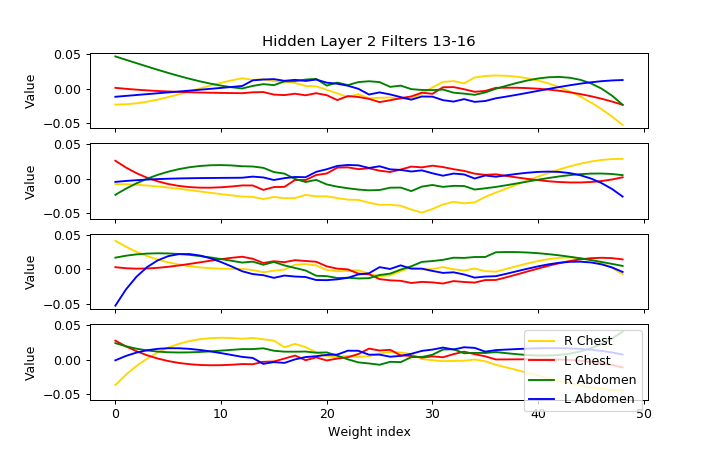

In [46]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+12, kernel_size, w_reshaped2)

ax1.set_title('Hidden Layer 2 Filters 13-16')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


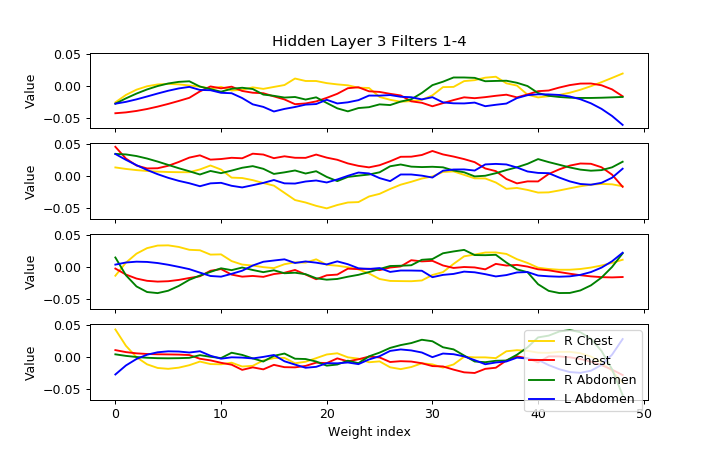

In [62]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 1-4')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


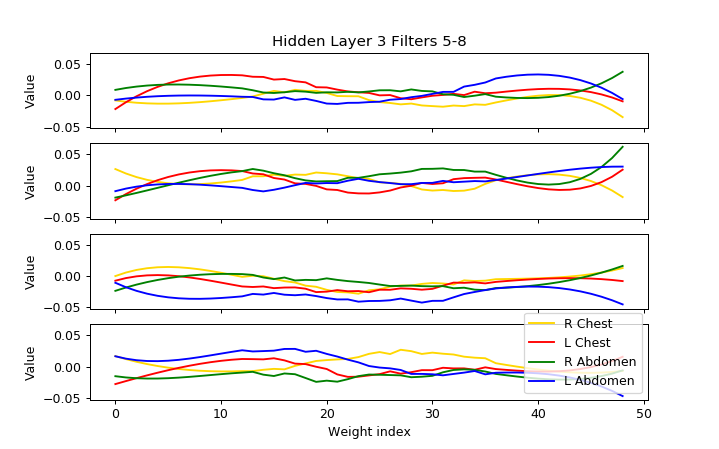

In [48]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+4, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 5-8')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


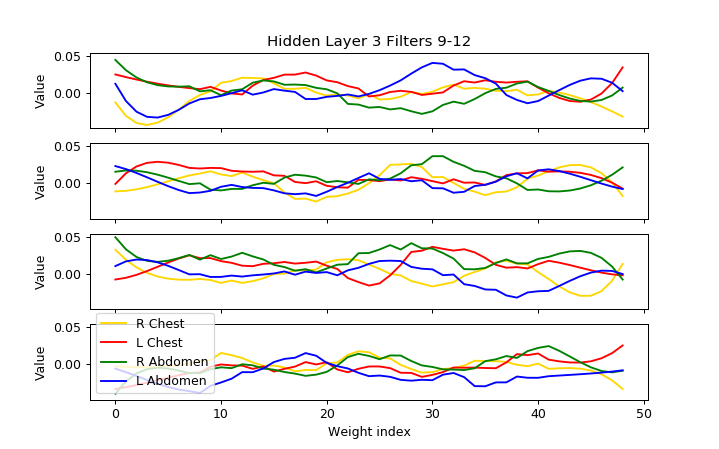

In [63]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+8, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 9-12')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


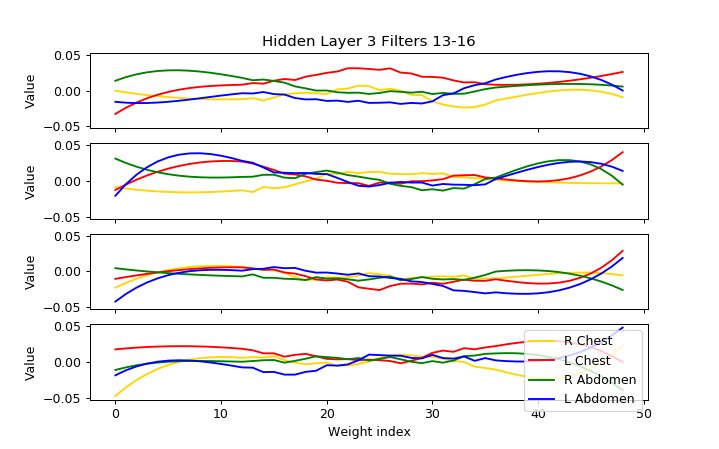

In [50]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+12, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 13-16')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


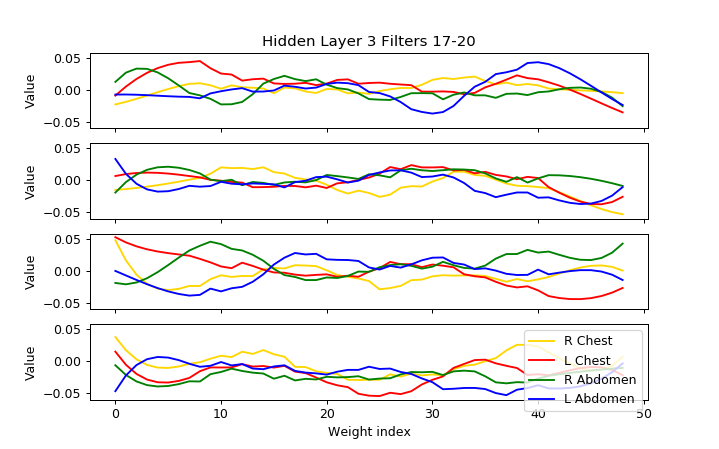

In [64]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+16, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 17-20')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


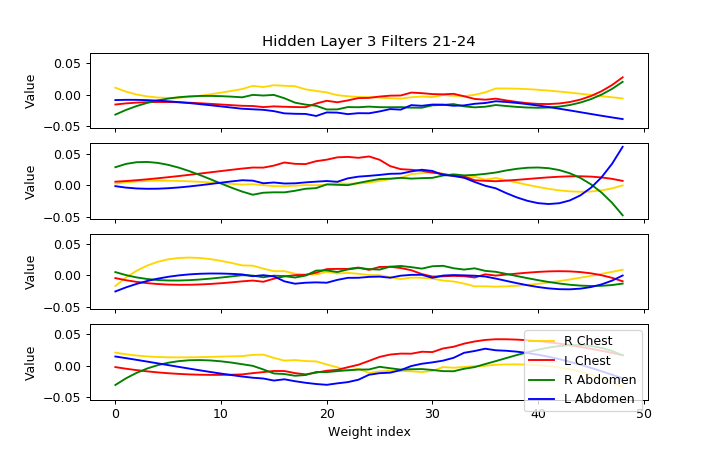

In [52]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+20, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 21-24')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


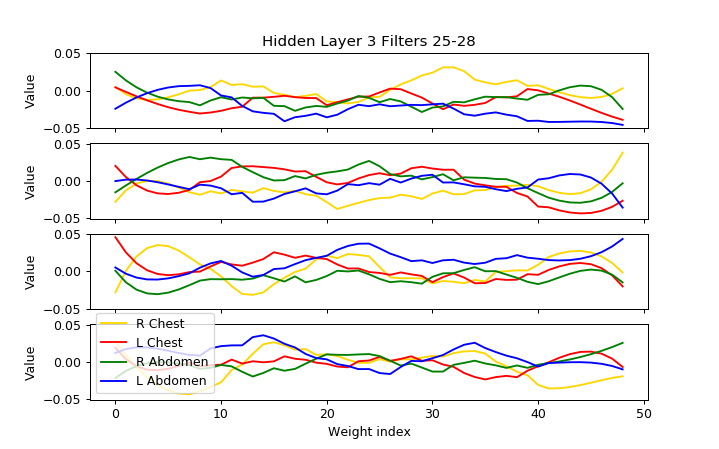

In [65]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+24, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 25-28')
plt.xlabel('Weight index')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


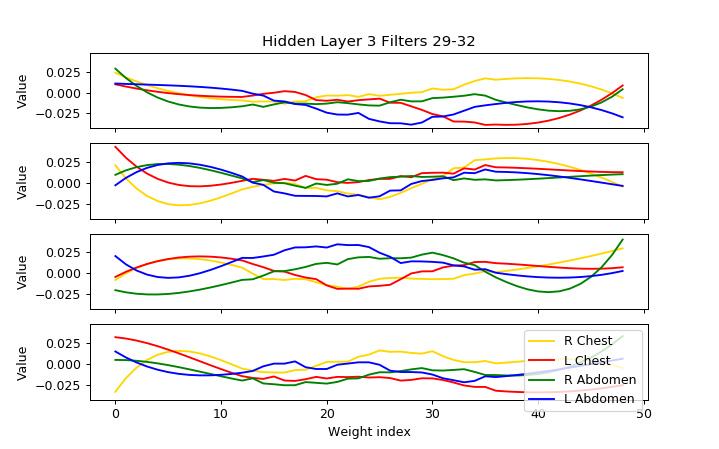

In [54]:
%matplotlib notebook

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=True, sharex=True, 
                                                             figsize=(8,5))
    
ax_list = [ax1, ax2, ax3, ax4]

for n, ax  in enumerate(ax_list):
    plot_smoothed_filter(ax, n+28, kernel_size, w_reshaped3)

ax1.set_title('Hidden Layer 3 Filters 29-32')
plt.xlabel('Weight index')
plt.legend()
plt.show()